In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from py_utils.FINDER_test_utils import *
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl

# Plot synthetic test set performance of specific models

## Specify test sets

In [4]:
test_set_0 = 'tsp_min-n=15_max-n=20_num-graph=1000_type=random'
test_set_1 = 'tsp_min-n=40_max-n=50_num-graph=1000_type=random'
test_set_2 = 'tsp_min-n=50_max-n=100_num-graph=1000_type=random'
test_set_names = [test_set_0, test_set_1, test_set_2]

In [6]:
test_set_0 = 'synthetic_n_20_1000'
test_set_1 = 'synthetic_n_50_1000'
test_set_names = [test_set_0, test_set_1]
test_set_names = [test_set_0]

## Specifiy model paths and model names (to load results files)

In [ ]:
model_names = [
    'AGNN_default_len_10113392076640768',
    'AGNN_RNN_len_10117276006490983'
        
]
search_strategies = [
    [
        'greedy',
        'beam_search+_64',
        'beam_search+_256'
    ],
    [
        'greedy'
    ]
    
]

In [8]:
model_names = [
    'AGNN_no_help_only_start_end_+_edge_prob_+_unfixed_start_2021-09-08_17:31:23_len_100143'
        
]
search_strategies = [
    [
        'beam_search+_128'
    ]
    
]


In [9]:

mean_approx_ratios = []
std_approx_ratios = []
for k, model_name in enumerate(model_names):
    for search_strategy in search_strategies[k]:
        means, stds = get_test_approx_ratios_for_model(test_set_names, model_name, search_strategy=search_strategy)
        mean_approx_ratios.append(means)
        std_approx_ratios.append(stds)
        print(means)
end_idx = len(test_set_names)
# s2v_dqn_mean_approx_ratios = [1.0147]#, 1.0511, 1.0702]
kool_am_approx_ratios = [1.0008, 1.0052, 1.0226][0:end_idx]
pomo_approx_ratios = [1.00004, 1.0003, 1.0014][0:end_idx]
sota_approx_ratios = [1.0000004, 1.000145, 1.00037][0:end_idx]

# mean_approx_ratios.append(s2v_dqn_mean_approx_ratios)
mean_approx_ratios.append(kool_am_approx_ratios)
mean_approx_ratios.append(pomo_approx_ratios)
mean_approx_ratios.append(sota_approx_ratios)
mean_errors = [list(100 * (np.array(entry) - 1)) for entry in mean_approx_ratios]

results/AGNN_no_help_only_start_end_+_edge_prob_+_unfixed_start_2021-09-08_17:31:23_len_100143/synthetic_n_20_1000
[1.000047193723866]


In [20]:
model_names_short = ['FINDER ' + ' '.join(model_name.split('_')[0:-13]) for model_name in model_names]
model_names_search = []
for k, model_name in enumerate(model_names_short):
    for search_strategy in search_strategies[k]:
        print(search_strategy)
        if 'greedy' in search_strategy:
            model_names_search.append(model_name)
        elif 'beam_search+' in search_strategy:
            width = search_strategy.split('_')[-1]
            new_name = f'{model_name} BS+ (width = {width})'
            model_names_search.append(new_name)
# model_names_search.append('S2V-DQN')
model_names_search.append('Kool et al. AM')
model_names_search.append('POMO, x8 augmentation')
model_names_search.append('State-of-the-art')

beam_search+_128


In [10]:
model_names_search

['FINDER AGNN no help only start end + edge prob + unfixed start',
 'FINDER AGNN no help only start end + edge prob + unfixed start BS+ (width = 128)',
 'S2V-DQN',
 'State-of-the-art']

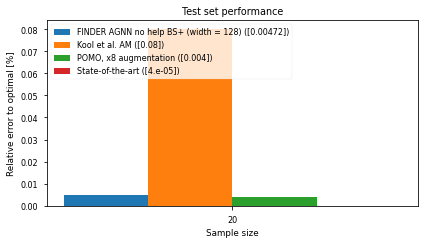

In [21]:
mpl.style.use('seaborn-paper')

fig, axs = plt.subplots(1, 1, figsize=(6,3.5), sharex=False, sharey=False)

width = 0.1
num_test_sets = len(mean_approx_ratios[0])
num_models = len(mean_approx_ratios)
# number of testsets
x = np.arange(0,num_test_sets)
for k, model_name in enumerate(model_names_search):
    offset = width * num_models / 2 - width / 2
    pos = x + k * width - offset
    axs.bar(pos, mean_errors[k], label=f'{model_name} ({np.round(mean_errors[k], 5)})', width=width)
axs.legend(loc='upper left')
axs.set_ylabel('Relative error to optimal [%]')
axs.set_title('Test set performance')
axs.set_xticks(x)
axs.set_xticklabels(['20'])
axs.set_xlabel('Sample size')
plt.tight_layout()
plt.savefig(f'plots/testset_performance_new.png', dpi=400)

In [54]:
search_strategy = 'greedy'

mean_approx_ratios = []
std_approx_ratios = []
for model_name in model_names:
    means, stds = get_test_approx_ratios_for_model(test_set_names, model_name, search_strategy=search_strategy)
    mean_approx_ratios.append(means)
    std_approx_ratios.append(stds)



s2v_dqn_mean_approx_ratios = [1.0147, 1.0511, 1.0702]
sota_approx_ratios = [1.0000, 1.002, 1.014]

mean_approx_ratios.append(s2v_dqn_mean_approx_ratios)
mean_approx_ratios.append(sota_approx_ratios)
mean_errors = [list(np.array(entry) - 1) for entry in mean_approx_ratios]


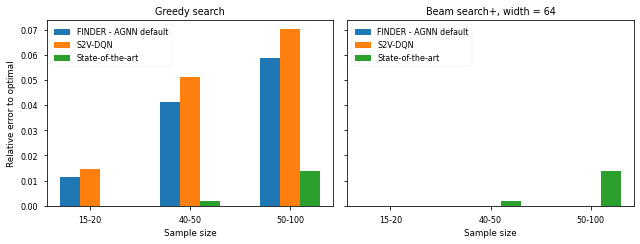

In [98]:
mpl.style.use('seaborn-paper')

fig, axs = plt.subplots(1, 2, figsize=(9,3.5), sharex=False, sharey=True)

width = 0.2
num_test_sets = len(mean_approx_ratios[0])
num_models = len(mean_approx_ratios)
# number of testsets
x = np.arange(0,num_test_sets)
for k, model_name in enumerate(model_names_short):
    offset = width * num_models / 2 - width / 2
    pos = x + k * width - offset
    axs[0].bar(pos, mean_errors[k], label=model_name, width=width)
# axs.grid(True, axis='y')
# axs.axhline(y = 1.015, color = 'black', linestyle = '--', label='S2V-DQN (1.0147)')
axs[0].legend(loc='upper left')
axs[0].set_ylabel('Relative error to optimal')
axs[0].set_title('Greedy search')


for k, model_name in enumerate(model_names_short):
    offset = width * num_models / 2 - width / 2
    pos = x + k * width - offset
    axs[1].bar(pos, mean_errors_beam[k], label=model_name, width=width)
axs[1].legend(loc='upper left')
axs[1].set_title('Beam search+, width = 64')


for ax in axs:
    ax.set_xticks(x)
    ax.set_xticklabels(['15-20', '40-50', '50-100'])
    ax.set_xlabel('Sample size')
    # ax.set_ylim([1, 1.075])
# plt.suptitle('Test set performance on S2V-DQN test sets (1000 samples each)')
plt.tight_layout()

plt.savefig(f'plots/testset_performance.png', dpi=400)

In [6]:
model_path_0 =  'best_models/tsp_2d/nrange_15_20_len_1011362/'
model_file_0, model_base_path, tour_length = get_model_file(model_path_0)
model_name_0 = model_file_0.split('.')[0]

model_path_2 =  'best_models/tsp_2d/nrange_15_20_len_1012015/' # 'best_models/tsp_2d/nrange_15_20_len_1011194/'
model_file_2, model_base_path, tour_length = get_model_file(model_path_2)
model_name_2 = model_file_2.split('.')[0]

Best model file: nrange_15_20_iter_3900_len_1011362.ckpt
Best model file: nrange_15_20_iter_1500_len_1012015.ckpt


In [7]:
model_names = [model_name_0, model_name_2]
mean_approx_ratio_list = []
for model_name in model_names:
    model_means = mean_approx_ratios_for_model(folder_names, model_name)
    mean_approx_ratio_list.append(model_means)

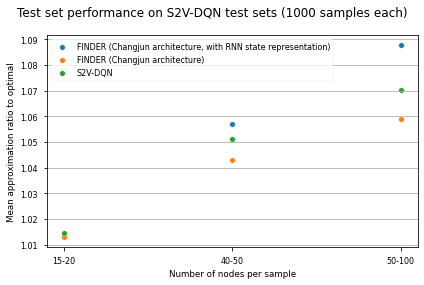

In [8]:
# architecture_0 = 'FINDER (Changjun architecture, selection through large validation set)'
architecture_0 = 'FINDER (Changjun architecture, with RNN state representation)'
architecture_1 = 'FINDER (Changjun architecture)'
mpl.style.use('seaborn-paper')

fig, axs = plt.subplots(1, 1, figsize=(6,4), sharex=True, sharey=True)
x = np.arange(0,len(mean_approx_ratio_list[0]))
sns.scatterplot(x=x,y=mean_approx_ratio_list[0], ax=axs, label=architecture_0)
sns.scatterplot(x=x,y=mean_approx_ratio_list[1], ax=axs, label=architecture_1)
sns.scatterplot(x=x,y=s2v_dqn_mean_approx_ratios, ax=axs, label='S2V-DQN')
axs.grid(True, axis='y')
# axs.axhline(y = 1.015, color = 'black', linestyle = '--', label='S2V-DQN (1.0147)')
axs.legend(loc='upper left')
axs.set_xticks(x)
axs.set_xticklabels(['15-20', '40-50', '50-100'])
axs.set_ylabel('Mean approximation ratio to optimal')
axs.set_xlabel('Number of nodes per sample')
# plt.suptitle('Test set performance on S2V-DQN test sets (1000 samples each)')
plt.tight_layout()

plt.savefig(f'plots/testset_performance_changjun.png', dpi=400)

In [8]:
model_path =  'best_models/tsp_2d/nrange_15_20_len_1012015/' # 'best_models/tsp_2d/nrange_15_20_len_1011194/'
model_file, model_base_path, tour_length = get_model_file(model_path)
model_name = model_file.split('.')[0]
model_names = [model_name]
mean_approx_ratio_list = []
for model_name in model_names:
    model_means = mean_approx_ratios_for_model(folder_names, model_name)
    mean_approx_ratio_list.append(model_means)

Best model file: nrange_15_20_iter_1500_len_1012015.ckpt


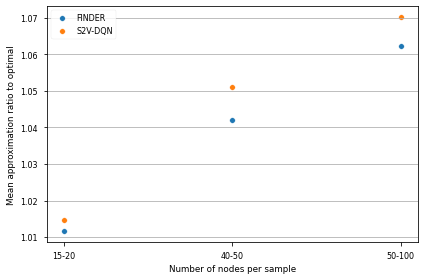

In [9]:
# architecture_0 = 'FINDER (Changjun architecture, selection through large validation set)'
architecture_0 = 'FINDER'
mpl.style.use('seaborn-paper')

fig, axs = plt.subplots(1, 1, figsize=(6,4), sharex=True, sharey=True)
x = np.arange(0,len(mean_approx_ratio_list[0]))
sns.scatterplot(x=x,y=mean_approx_ratio_list[0], ax=axs, label=architecture_0)
sns.scatterplot(x=x,y=s2v_dqn_mean_approx_ratios, ax=axs, label='S2V-DQN')
axs.grid(True, axis='y')
# axs.axhline(y = 1.015, color = 'black', linestyle = '--', label='S2V-DQN (1.0147)')
axs.legend(loc='upper left')
axs.set_xticks(x)
axs.set_xticklabels(['15-20', '40-50', '50-100'])
axs.set_ylabel('Mean approximation ratio to optimal')
axs.set_xlabel('Number of nodes per sample')
# plt.suptitle('Test set performance on S2V-DQN test sets (1000 samples each)')
plt.tight_layout()

plt.savefig(f'plots/testset_performance_FINDER_current.png', dpi=400)